#1. Package Install

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd
import keras
import json
import math
import tensorflow as tf 
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Conv2D, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, RandomContrast
from keras.layers import MaxPooling2D, RandomTranslation
from tensorflow.keras.layers import RandomBrightness
from keras import optimizers
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import MobileNetV2
#from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import shutil
from keras.utils import plot_model
from tqdm.notebook import tqdm

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#2. Data Loading

##2.0. File Paths

In [ ]:
cat_image_filepath = '/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/YTBB_images/19_dog/19_dog/'
dog_image_filepath = '/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/YTBB_images/07_cat/07_cat/'
sliced_image_filepath = '/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/YTBB_images/consolidated/'
thumbnail_filepath = '/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/YTBB_thumbnails/'
npz_path_base = '/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/npz_files_v2/'

##2.1. Data Loading (Sliced Video Images)

In [ ]:
image_width = 240
image_height = 180

def get_img(img_path, printer=True):
  original_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  if printer: print ("original dim:",original_img.shape)
  resized_img = cv2.resize(original_img, (image_width, image_height), interpolation=cv2.INTER_AREA) #cv2.INTER_AREA for reduction of width and height
  resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) #Change bgr to rgb
  if printer: print ("resized dim:", resized_img.shape)
  return resized_img
#07_cat, 19_dog folder (dog:13,648 files, cat:13,221 files)

In [ ]:
#Move sliced image files to consolidated folder
files_cat = os.listdir(path=cat_image_filepath)
print(len(files_cat))
files_dog = os.listdir(path=dog_image_filepath)
print(len(files_dog))

for i in range(len(files_cat)):
  path_before_move = cat_image_filepath + files_cat[i]
  path_after_move = sliced_image_filepath + files_cat[i]
  shutil.move(path_before_move, path_after_move)
  print(str(i)+" / "+str(len(files_cat))+" is done")

for i in range(len(files_dog)):
  path_before_move = dog_image_filepath + files_dog[i]
  path_after_move = sliced_image_filepath + files_dog[i]
  shutil.move(path_before_move, path_after_move)
  print(str(i)+" / "+str(len(files_dog))+" is done")

0
0


In [ ]:
#Check total number of sliced images
sliced_image_files = os.listdir(path=sliced_image_filepath)
print(len(sliced_image_files)) #26,867 images (out of 26,869 images)

26867


In [ ]:
sliced_image_file_name = pd.DataFrame(sliced_image_files)
display_id = pd.DataFrame(pd.Series(sliced_image_files).str[3:14],index=np.arange(0,len(sliced_image_files),1))
sliced_image_file_path = pd.DataFrame(sliced_image_filepath + pd.Series(sliced_image_files))
sliced_image_file_df = pd.concat([sliced_image_file_name, display_id, sliced_image_file_path], axis=1)
sliced_image_file_df.columns = ['sliced_image_file_name','display_id', 'sliced_image_file_path']

In [ ]:
sliced_image_file_df.to_csv('/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/sliced_image_file_df.csv')

In [ ]:
sliced_image_files[0:5]

['19+-4m50vf5NYc+00+0195000+1.jpg',
 '07+-72mHBEBwq8+00+0008000+1.jpg',
 '07+-6NMINfiUig+01+0375000+1.jpg',
 '19+-PcypeOjrgQ+01+0078000+1.jpg',
 '07+-6NMINfiUig+00+0332000+1.jpg']

original dim: (720, 1280, 3)
resized dim: (180, 240, 3)


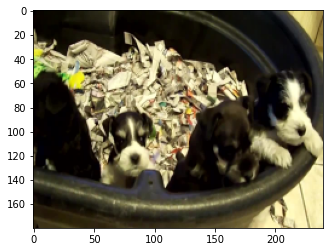

In [ ]:
resized_img = get_img(sliced_image_filepath+sliced_image_files[5])
plt.imshow(resized_img)

##2.2. Data Loading (Thubmnail Files)

In [ ]:
#Consolidate information regarding thumbnail files
thumbnail_file_name = pd.Series(os.listdir('/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/YTBB_thumbnails'))
display_id = pd.DataFrame(thumbnail_file_name.str[0:11],index=np.arange(0,len(thumbnail_file_name),1))
thumbnail_file_path = pd.DataFrame(thumbnail_filepath + '/' + thumbnail_file_name)

thumbnail_file_df = pd.DataFrame(list(thumbnail_file_name),index=np.arange(0,len(thumbnail_file_name),1))
thumbnail_file_df = pd.concat([thumbnail_file_df, display_id, thumbnail_file_path],axis=1)
thumbnail_file_df.columns = ['thumbnail_file_name','display_id', 'thumbnail_file_path']
thumbnail_file_df #1208 rows

,thumbnail_file_name,display_id,thumbnail_file_path
0,3TfEAqnwDiY.jpg,3TfEAqnwDiY,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1,3TGAhZRLG_U.jpg,3TGAhZRLG_U,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
2,3R2RqggIx38.jpg,3R2RqggIx38,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
3,3QL9Q0vAK_s.jpg,3QL9Q0vAK_s,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
4,3OcVFTkXKJ0.jpg,3OcVFTkXKJ0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...
1203,2KzZ0mAzsCM.jpg,2KzZ0mAzsCM,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1204,2MjzSA2LFm4.jpg,2MjzSA2LFm4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1205,2lxgIdb-vP8.jpg,2lxgIdb-vP8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1206,2_NCYFDnihQ.jpg,2_NCYFDnihQ,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
#blank = np.where(np.array(number_of_sliced_images) == 0)[0]
#thumbnail_file_df.iloc[blank]
#	3ra5ng0uq9I does not have sliced images

#Exclude blank video
delete = np.where(np.array(thumbnail_file_df['display_id'] == '3ra5ng0uq9I'))[0][0] #Index of 3ra5ng0uq9I
thumbnail_file_df = thumbnail_file_df.drop([delete],axis=0)
thumbnail_file_df = thumbnail_file_df.reset_index(drop=True)
thumbnail_file_df #1207 rows

#Check number of sliced images per video
#plt.plot(number_of_sliced_images)
#plt.hlines(18,0,1208) #Number of sliced images per video is 18 for almost videos

,thumbnail_file_name,display_id,thumbnail_file_path
0,3TfEAqnwDiY.jpg,3TfEAqnwDiY,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1,3TGAhZRLG_U.jpg,3TGAhZRLG_U,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
2,3R2RqggIx38.jpg,3R2RqggIx38,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
3,3QL9Q0vAK_s.jpg,3QL9Q0vAK_s,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
4,3OcVFTkXKJ0.jpg,3OcVFTkXKJ0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...
1202,2KzZ0mAzsCM.jpg,2KzZ0mAzsCM,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1203,2MjzSA2LFm4.jpg,2MjzSA2LFm4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1204,2lxgIdb-vP8.jpg,2lxgIdb-vP8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1205,2_NCYFDnihQ.jpg,2_NCYFDnihQ,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


##2.3. Data Loading (Metadata)

In [ ]:
#Match meta data with thumbnail file data
metadata_df = pd.read_csv('/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/input_metadata_consolidated.csv',
                          index_col=0)
metadata_df = metadata_df[['display_id','view_count','like_count','duration','width','height','fps']]
metadata_df #1208 rows

merged_df = pd.merge(thumbnail_file_df,metadata_df, how="inner", on="display_id")
merged_df #1207 rows (by deleting 3ra5ng0uq9I)

,thumbnail_file_name,display_id,thumbnail_file_path,view_count,like_count,duration,width,height,fps
0,3TfEAqnwDiY.jpg,3TfEAqnwDiY,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,135,2,74,640,480,14
1,3TGAhZRLG_U.jpg,3TGAhZRLG_U,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,12444,2,40,640,480,30
2,3R2RqggIx38.jpg,3R2RqggIx38,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,4541,2,42,640,480,30
3,3QL9Q0vAK_s.jpg,3QL9Q0vAK_s,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,709,0,114,1280,720,30
4,3OcVFTkXKJ0.jpg,3OcVFTkXKJ0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,225,0,128,720,480,30
...,...,...,...,...,...,...,...,...,...
1202,2KzZ0mAzsCM.jpg,2KzZ0mAzsCM,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,943,1,70,192,144,11
1203,2MjzSA2LFm4.jpg,2MjzSA2LFm4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,793,12,78,1280,720,30
1204,2lxgIdb-vP8.jpg,2lxgIdb-vP8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,337,1,62,426,240,30
1205,2_NCYFDnihQ.jpg,2_NCYFDnihQ,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,990,0,40,640,480,30


#3. Data Consolidation (NPZ file creation)

##3.1. Choose sliced images per display id (video id)

In [ ]:
#Choose sliced images per video id
X_check = []
number_of_sliced_images = []
number_of_sliced_images_per_video = 18

for i in range(thumbnail_file_df.shape[0]):
  X_sample = []
  display_id = thumbnail_file_df['display_id'][i]
  selected_sliced_images = np.where(sliced_image_file_df['display_id'] == display_id)[0]
  img_paths = sliced_image_file_df.iloc[selected_sliced_images].sort_values(by="sliced_image_file_name")['sliced_image_file_path']
  
  if len(img_paths) < number_of_sliced_images_per_video:
    if len(img_paths) > number_of_sliced_images_per_video-len(img_paths):
      addtional_img_paths = img_paths.sample(n=number_of_sliced_images_per_video-len(img_paths), random_state=0, replace=False)
      img_paths = pd.concat([img_paths, addtional_img_paths])
      img_paths = img_paths.sort_values()
    else:
      addtional_img_paths = img_paths.sample(n=number_of_sliced_images_per_video-len(img_paths), random_state=0, replace=True)
      img_paths = pd.concat([img_paths, addtional_img_paths])
      img_paths = img_paths.sort_values()
  elif len(img_paths) > number_of_sliced_images_per_video:
    img_paths = img_paths.sample(n=number_of_sliced_images_per_video, random_state=0, replace=False)
    img_paths = img_paths.sort_values()
  
  for img_path in img_paths:
    resized_img = get_img(img_path, printer=False)
    X_sample.append(resized_img)
  
  number_of_sliced_images.append(len(img_paths))
  X_check.append(np.array(X_sample))
  print(str(i+1)+"/"+str(thumbnail_file_df.shape[0])+" is done")

1/1207 is done
2/1207 is done
3/1207 is done
4/1207 is done
5/1207 is done
6/1207 is done
7/1207 is done
8/1207 is done
9/1207 is done
10/1207 is done
11/1207 is done
12/1207 is done
13/1207 is done
14/1207 is done
15/1207 is done
16/1207 is done
17/1207 is done
18/1207 is done
19/1207 is done
20/1207 is done
21/1207 is done
22/1207 is done
23/1207 is done
24/1207 is done
25/1207 is done
26/1207 is done
27/1207 is done
28/1207 is done
29/1207 is done
30/1207 is done
31/1207 is done
32/1207 is done
33/1207 is done
34/1207 is done
35/1207 is done
36/1207 is done
37/1207 is done
38/1207 is done
39/1207 is done
40/1207 is done
41/1207 is done
42/1207 is done
43/1207 is done
44/1207 is done
45/1207 is done
46/1207 is done
47/1207 is done
48/1207 is done
49/1207 is done
50/1207 is done
51/1207 is done
52/1207 is done
53/1207 is done
54/1207 is done
55/1207 is done
56/1207 is done
57/1207 is done
58/1207 is done
59/1207 is done
60/1207 is done
61/1207 is done
62/1207 is done
63/1207 is done
6

In [ ]:
#Result validation
print(pd.DataFrame(number_of_sliced_images).describe())
print(np.array(X_check).shape) #1207 videos x 18 slices x 180 height x 240 width x 3 channels

            0
count  1207.0
mean     18.0
std       0.0
min      18.0
25%      18.0
50%      18.0
75%      18.0
max      18.0
(1207, 18, 180, 240, 3)


In [ ]:
y_check = np.array(merged_df[['view_count','like_count']])
y_check.shape #1207 videos x 2 metrics (view_count, like_count)

(1207, 2)

In [ ]:
#Compress data into npz files
npz_paths = []
thumnail_width = 224
thumnail_height = 224
dim = (thumnail_width, thumnail_height)

for i,row in merged_df.iterrows():
  picture_path = row['thumbnail_file_path']
  npz_path = npz_path_base + row['display_id'] + '.npz'
  npz_paths.append(npz_path)

  pic_bgr_arry = cv2.imread(picture_path)
  resized_pic = cv2.resize(pic_bgr_arry, dim, interpolation = cv2.INTER_AREA)
  pic_rbg_arry = cv2.cvtColor(resized_pic, cv2.COLOR_BGR2RGB)

  width, height, fpss, durataion = row['width'], row['height'], row['fps'], row['duration']
  stats = np.array([width, height, fpss, durataion])
  view_count = row['view_count']
  like_count = row['like_count']
  sliced_video_images = X_check[i]

  #Compress the data
  np.savez_compressed(npz_path, pic=pic_rbg_arry, sliced_video_images=sliced_video_images, 
                      stats=stats, view_count=view_count, like_count=like_count)
  print("Compressing data into npz files... "+str(i+1)+"/"+str(merged_df.shape[0])+" is done")

#Need to add 'NPZ_Files' column to merged data
merged_df['NPZ_Files'] = pd.Series(npz_paths)
merged_df.to_csv('/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/merged_df_with_npz.csv')

Compressing data into npz files... 1/1207 is done
Compressing data into npz files... 2/1207 is done
Compressing data into npz files... 3/1207 is done
Compressing data into npz files... 4/1207 is done
Compressing data into npz files... 5/1207 is done
Compressing data into npz files... 6/1207 is done
Compressing data into npz files... 7/1207 is done
Compressing data into npz files... 8/1207 is done
Compressing data into npz files... 9/1207 is done
Compressing data into npz files... 10/1207 is done
Compressing data into npz files... 11/1207 is done
Compressing data into npz files... 12/1207 is done
Compressing data into npz files... 13/1207 is done
Compressing data into npz files... 14/1207 is done
Compressing data into npz files... 15/1207 is done
Compressing data into npz files... 16/1207 is done
Compressing data into npz files... 17/1207 is done
Compressing data into npz files... 18/1207 is done
Compressing data into npz files... 19/1207 is done
Compressing data into npz files... 20/12

In [ ]:
#Separate the data into train data and test data
#X_train, X_test, y_train, y_test = train_test_split(X_check, y_check, test_size=0.1)
#print(np.array(X_train).shape)
#print(np.array(X_test).shape)
#print(np.array(y_train).shape)
#print(np.array(y_test).shape)

In [ ]:
#Testing npz
sample_npz = np.load('/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/npz_files_v2/-_h-W3_9o0I.npz')
print(sample_npz['pic'].shape)
print(sample_npz['stats'].shape)
print(sample_npz['sliced_video_images'].shape)
print(sample_npz['view_count'].shape)
print(sample_npz['like_count'].shape)

(224, 224, 3)
(4,)
(18, 180, 240, 3)
()
()


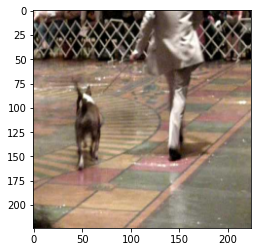

In [ ]:
# import matplotlib.pyplot as plt
plt.imshow(sample_npz['pic'])

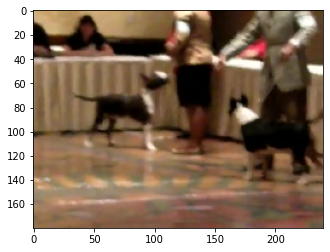

In [ ]:
plt.imshow(sample_npz['sliced_video_images'][17])

#4. Data Preparation (middle start)

In [ ]:
# Middle_Start
merged_df = pd.read_csv('/content/gdrive/MyDrive/NUS/ISY5002_project_work/001_input_data/imagefiles/merged_df_with_npz.csv',index_col=0) 
merged_df = merged_df.dropna()
merged_df

,thumbnail_file_name,display_id,thumbnail_file_path,view_count,like_count,duration,width,height,fps,NPZ_Files
0,3TfEAqnwDiY.jpg,3TfEAqnwDiY,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,135,2,74,640,480,14,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1,3TGAhZRLG_U.jpg,3TGAhZRLG_U,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,12444,2,40,640,480,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
2,3R2RqggIx38.jpg,3R2RqggIx38,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,4541,2,42,640,480,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
3,3QL9Q0vAK_s.jpg,3QL9Q0vAK_s,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,709,0,114,1280,720,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
4,3OcVFTkXKJ0.jpg,3OcVFTkXKJ0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,225,0,128,720,480,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...,...,...,...,...,...,...,...
1202,2KzZ0mAzsCM.jpg,2KzZ0mAzsCM,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,943,1,70,192,144,11,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1203,2MjzSA2LFm4.jpg,2MjzSA2LFm4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,793,12,78,1280,720,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1204,2lxgIdb-vP8.jpg,2lxgIdb-vP8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,337,1,62,426,240,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1205,2_NCYFDnihQ.jpg,2_NCYFDnihQ,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,990,0,40,640,480,30,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
merged_df.drop(['thumbnail_file_name','thumbnail_file_path','duration','width','height','fps'], inplace = True, axis=1)
merged_df

,display_id,view_count,like_count,NPZ_Files
0,3TfEAqnwDiY,135,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1,3TGAhZRLG_U,12444,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
2,3R2RqggIx38,4541,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
3,3QL9Q0vAK_s,709,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
4,3OcVFTkXKJ0,225,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...,...
1202,2KzZ0mAzsCM,943,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1203,2MjzSA2LFm4,793,12,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1204,2lxgIdb-vP8,337,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1205,2_NCYFDnihQ,990,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
shuffled_df = merged_df.sample(frac=1, random_state=0)
shuffled_df

,display_id,view_count,like_count,NPZ_Files
592,3DKlcBW3jW8,553,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
5,3NdohI0ZTj4,495,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
141,0QerbXHbsXo,559,8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
453,1VluC3M16HI,559,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
52,2h_F8niDeKA,2821,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...,...
1033,17ShHvfDLMQ,429,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
763,-BGQp5jmoqQ,1106,18,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
835,-LpN5tH_TeA,4434,9,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
559,3o8TdfUYffU,273650,1536,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
train_df, val_df, test_df = shuffled_df[:1000], shuffled_df[1000:1100], shuffled_df[1100:shuffled_df.shape[0]]
print(len(train_df),len(val_df),len(test_df))
# now the data is ready in these dframes

1000 100 107


In [ ]:
test_df

,display_id,view_count,like_count,NPZ_Files
1082,10uqRAUSeYo,3247,4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
1065,0jcdVWRH2y8,424,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
782,-98PnVmVa8g,880,4,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
562,3pMgGliu6pM,906,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
209,-ULQSGy5d3o,1132124,6867,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...,...
1033,17ShHvfDLMQ,429,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
763,-BGQp5jmoqQ,1106,18,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
835,-LpN5tH_TeA,4434,9,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
559,3o8TdfUYffU,273650,1536,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
# function to get X_pic, X_stats, and y from a DataFrame
def get_X_y(df):
  X_pic, X_metadata, X_sliced_video_images = [], [], []
  y1 = []
  y2 = []
  k = 0 #counter
  for name in df['NPZ_Files']:
    loaded_npz = np.load(name)
    pic = loaded_npz['pic']
    stats = loaded_npz['stats']
    sliced_video_images = loaded_npz['sliced_video_images']
    X_pic.append(pic)
    X_metadata.append(stats)
    X_sliced_video_images.append(sliced_video_images)
    y1.append([loaded_npz['like_count']])
    y2.append([loaded_npz['view_count']])    
    print(k)
    k += 1
  X_pic, X_metadata, X_sliced_video_images = np.array(X_pic), np.array(X_metadata), np.array(X_sliced_video_images)
  y1 = np.array(y1)
  y2 = np.array(y2)
  return (X_pic, X_metadata, X_sliced_video_images), (y1, y2)

In [ ]:
#Loading the data may take 10 mins
(X_train_pic, X_train_stats, X_train_sliced_video_images), (y1_train, y2_train) = get_X_y(train_df) #Train data
(X_val_pic, X_val_stats, X_val_sliced_video_images), (y1_val, y2_val) = get_X_y(val_df) #Validation data
(X_test_pic, X_test_stats, X_test_sliced_video_images), (y1_test, y2_test) = get_X_y(test_df) #Test data

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#5. Model Design (1st model to predict like count)

In [ ]:
#Load InceptionResNet V2
image_width = 240
image_height = 180

inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(image_height,image_width,3)
)

#Train only the last 4 layers while Freezing the other layers.
for layer in inceptionresnet.layers[:-4]:
    layer.trainable = False

In [ ]:
#1:Thumbnail file tree (deep convolutional network)
image_shape=(224,224,3)
input_pic = Input(shape=image_shape)
#Data augumentation:Filp -> Rotation -> Translation -> Zoom -> Contrast -> Braightness (different order may result in bad results)
x1 = RandomFlip("horizontal_and_vertical")(input_pic)
x1 = RandomRotation(0.1)(x1) #0.3 in the previous version. 0.1 is also to some extent good.
x1 = RandomTranslation(height_factor=0.2, width_factor=0.2)(x1) #0.2 in the previous version
x1 = RandomZoom(0.1)(x1) #0.3 in the previous version. 0.1 is also to some extent good.
x1 = RandomContrast(0.2)(x1) #0.2 in the previous version
x1 = RandomBrightness([-0.6,0.6])(x1) #-0.6 - 0.6 in the previous version.
x1 = Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(128, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(128, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = keras.layers.Flatten()(x1)
#fc11=Dense(4096, activation='relu')(fc1)
#fc12=Dense(4096, activation='relu')(fc11)
#fc13=Dense(2, activation='softmax')(fc12)
x1 = Model(inputs=input_pic, outputs=x1)

#2:Metadata tree
input_stats = layers.Input(shape=(4,))
x2 = layers.Dense(64, activation="relu")(input_stats)
x2 = layers.Dense(10, activation="relu")(x2)
x2 = Model(inputs=input_stats, outputs=x2)

#3:Sliced video image tree
number_of_sliced_images_per_video = 18
image_width = 240
image_height = 180

#0.1 -> too high
#0.2 -> still fluctuated
#0.25 -> the
#0.35, 0.4 -> reduce prediction level
input_sliced_images = layers.Input(shape=(number_of_sliced_images_per_video, image_height, image_width, 3))
x3 = TimeDistributed(RandomRotation(0.1))(input_sliced_images) #0.2 is the best so far. 0.1 testing now
x3 = TimeDistributed(RandomTranslation(height_factor=0.25, width_factor=0.2))(x3) #0.2 is the best so far. (0.25, 0.2) is not bad.
x3 = TimeDistributed(RandomZoom(0.2))(x3) #0.25 is the best so far. Testing 0.2 now.
#x3 = TimeDistributed(RandomContrast(0.2))(x3) #By including this, the prediction inflates
x3 = TimeDistributed(inceptionresnet)(x3)
x3 = TimeDistributed(Flatten())(x3)
x3 = LSTM(256, activation='relu', return_sequences=False)(x3)
x3 = layers.Dense(64, activation='relu')(x3)
x3 = Dropout(.5)(x3)
x3 = layers.Dense(2, activation="linear")(x3)
x3 = Model(inputs=input_sliced_images, outputs=x3)

#4:Integration layer 1 (#1, #2, #3 to calculate like count)
combined = layers.concatenate([x1.output, x2.output, x3.output])
y1 = layers.Flatten()(combined)
y1 = layers.Dense(1, activation="linear")(y1)
#Define the model
y1_model = Model(inputs=[x1.input, x2.input, x3.input], outputs=y1)

In [ ]:
y1_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 random_rotation_2 (RandomRotat  (None, 224, 224, 3)  0          ['random_flip_1[0][0]']          
 ion)                                                                                             
                                                                                            

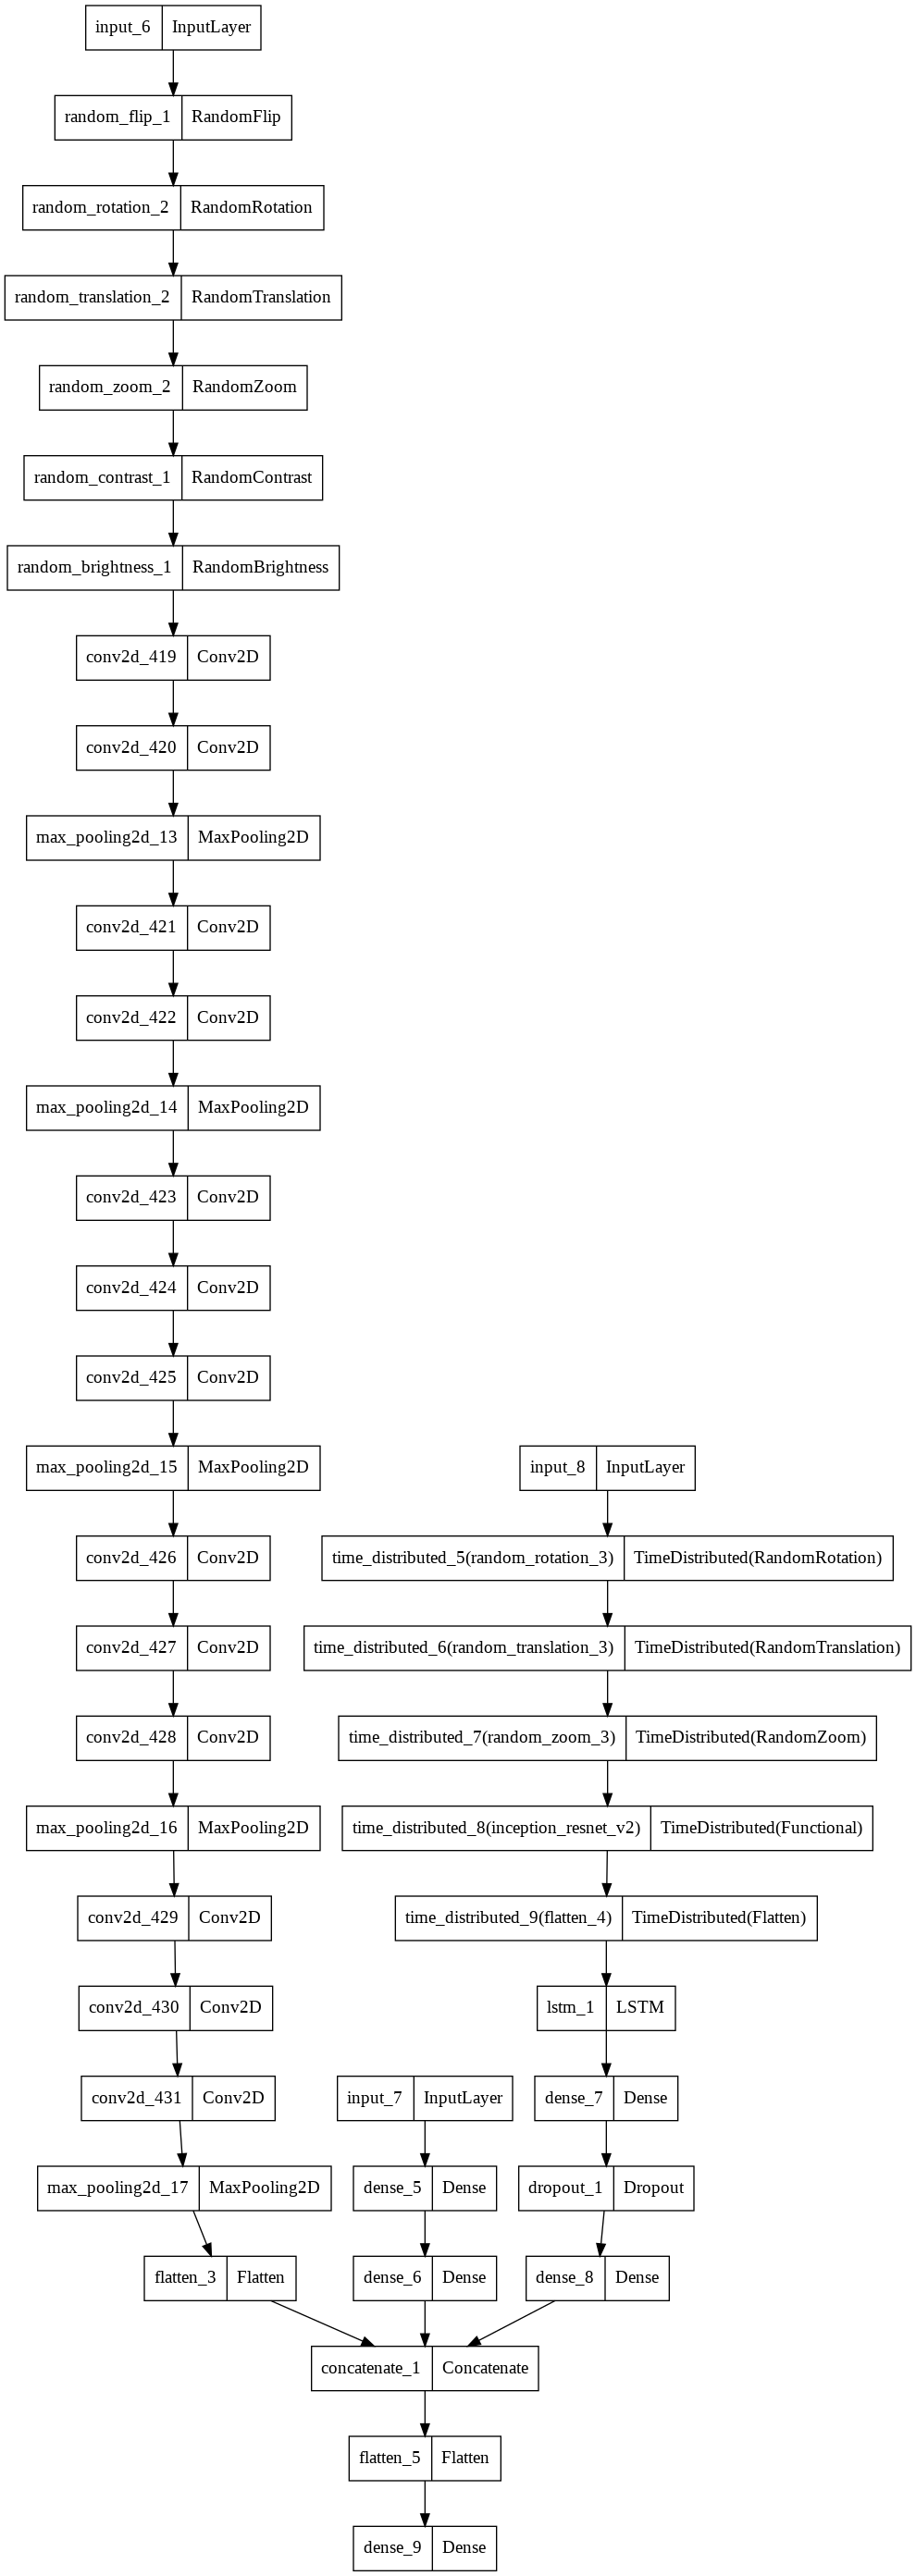

In [ ]:
plot_model(y1_model, to_file='Cnn + Metadata.png')

In [ ]:
y1_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error','mean_squared_error'])
#learning_rate should be small enough. Otherwise, the traning process may not work

#6. Model Training (1st model to predict like count)

In [ ]:
# Create a model saving callback and train for 3 epochs (connect to GPU runtime!!)
from keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model/', save_best_only=True)
tf.get_logger().setLevel('ERROR') #do not show warning due to data augumentation
r = y1_model.fit(x=[X_train_pic, X_train_stats, X_train_sliced_video_images], y=y1_train, 
              validation_data=([X_val_pic, X_val_stats, X_val_sliced_video_images], y1_val), epochs=3, callbacks=[cp])

Epoch 1/3
32/32 [==============================] - ETA: 0s - loss: 992055.6250 - mean_absolute_error: 194.5938 - mean_squared_error: 992055.6250   

32/32 [==============================] - 671s 20s/step - loss: 992055.6250 - mean_absolute_error: 194.5938 - mean_squared_error: 992055.6250 - val_loss: 23216.2734 - val_mean_absolute_error: 130.5861 - val_mean_squared_error: 23216.2734
Epoch 2/3
32/32 [==============================] - ETA: 0s - loss: 580214.9375 - mean_absolute_error: 103.0734 - mean_squared_error: 580214.9375 

32/32 [==============================] - 642s 20s/step - loss: 580214.9375 - mean_absolute_error: 103.0734 - mean_squared_error: 580214.9375 - val_loss: 9854.7666 - val_mean_absolute_error: 66.4385 - val_mean_squared_error: 9854.7666
Epoch 3/3
32/32 [==============================] - ETA: 0s - loss: 581316.8125 - mean_absolute_error: 99.7201 - mean_squared_error: 581316.8125 

32/32 [==============================] - 633s 20s/step - loss: 581316.8125 - mean_absolute_error: 99.7201 - mean_squared_error: 581316.8125 - val_loss: 8247.7549 - val_mean_absolute_error: 53.5670 - val_mean_squared_error: 8247.7549


In [82]:
# Load the saved model
y1_model.save("/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/CNN+LSTM_models_like_count")

In [ ]:
#from keras.models import load_model
#y1_model = load_model("/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/CNN+LSTM_models_like_count")

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


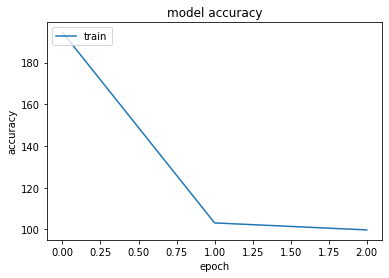

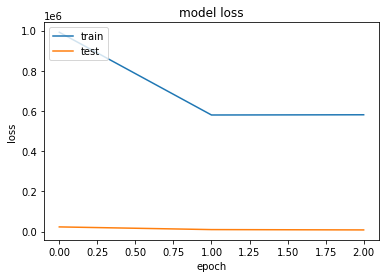

In [ ]:
print(r.history.keys())
# summarize history for accuracy
plt.plot(r.history['mean_absolute_error'])
#plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim(0,0.5e9)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#7. Test Prediction and Result Evaluation  (1st model to predict like count)

In [ ]:
# loaded model to obtain predictions on the test set
#(X_test_pic, X_test_stats, X_test_sliced_video_images), y_test = get_X_y(test_df) #Test data
#test_predictions = []
#number_of_test_samples = X_test_sliced_video_images.shape[0]
test_predictions = y1_model.predict([X_test_pic, X_test_stats, X_test_sliced_video_images])

#for i in range(number_of_test_samples):
# pred = model.predict([X_test_pic[i],X_test_stats[i],X_test_sliced_video_images[i]])
#  test_predictions.append(pred)
#  print(str(i+1)+"/"+str(number_of_test_samples)+" is done")

4/4 [==============================] - 8s 812ms/step


In [ ]:
print(X_test_pic.shape)
print(X_test_stats.shape)
print(X_test_sliced_video_images.shape)

print(X_test_pic[0].shape)
print(X_test_stats[0].shape)
print(X_test_sliced_video_images[0].shape)

print(type(X_test_pic))
print(type(X_test_stats))
print(type(X_test_sliced_video_images))

(107, 224, 224, 3)
(107, 4)
(107, 18, 180, 240, 3)
(224, 224, 3)
(4,)
(18, 180, 240, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
test_predictions

array([[114.34738 ],
       [ 43.482895],
       [ 58.64075 ],
       [ 62.234577],
       [ 98.366394],
       [ 64.49347 ],
       [ 58.233818],
       [ 77.516685],
       [ 52.918964],
       [ 73.04223 ],
       [ 52.02536 ],
       [ 66.74121 ],
       [ 91.87915 ],
       [ 48.651016],
       [ 55.351833],
       [ 71.53128 ],
       [ 70.50876 ],
       [ 61.41997 ],
       [ 63.008045],
       [ 60.223064],
       [ 48.559456],
       [ 59.441994],
       [ 48.264008],
       [ 54.10824 ],
       [ 60.500164],
       [ 62.26374 ],
       [ 69.27977 ],
       [ 70.915794],
       [ 46.875767],
       [ 74.35884 ],
       [ 77.83891 ],
       [ 53.414963],
       [ 83.01665 ],
       [ 76.91107 ],
       [ 59.432095],
       [ 53.327583],
       [ 54.6113  ],
       [ 92.967514],
       [ 94.46374 ],
       [ 55.53606 ],
       [128.29727 ],
       [ 74.33634 ],
       [ 54.687374],
       [ 47.609722],
       [ 69.34733 ],
       [105.74144 ],
       [ 79.36737 ],
       [ 49.9

In [ ]:
y1_test_df = pd.DataFrame(y1_test)
test_predictions_df = pd.DataFrame(test_predictions)

y1_test_df.columns = ['like_count']
test_predictions_df.columns = ['predicted_like_count']

test_result = pd.concat([y1_test_df,test_predictions_df],axis=1)
test_result = test_result.sort_values(by='like_count',axis=0,ascending=False)

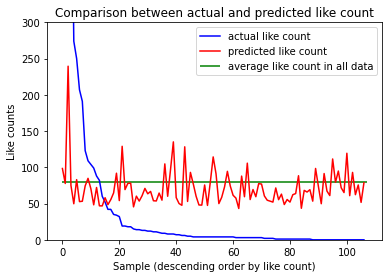

In [ ]:
#Comparison with average
avg = merged_df['like_count'].mean()
plt.ylim(0,300)
plt.xlabel("Sample (descending order by like count)")
plt.ylabel("Like counts")
plt.title("Comparison between actual and predicted like count")
plt.hlines(avg,0,test_result.shape[0],color='g',label='average like count in all data')
plt.plot(np.arange(0,test_result.shape[0],1),test_result['like_count'],color='b',label='actual like count')
plt.plot(np.arange(0,test_result.shape[0],1),test_result['predicted_like_count'],color='r',label='predicted like count')
plt.legend()

In [ ]:
test_result

,like_count,predicted_like_count
4,6867,98.366394
105,1536,77.709206
66,1517,239.507843
72,607,74.959923
74,274,49.740864
...,...,...
37,0,92.967514
25,0,62.263741
87,0,75.654671
56,0,51.629539


In [ ]:
avg

79.73322286661143

In [ ]:
q1 = merged_df['like_count'].quantile(q=0.25)
q2 = merged_df['like_count'].quantile(q=0.5)
q3 = merged_df['like_count'].quantile(q=0.75)
avg = merged_df['like_count'].mean()

like_count_category_avg = []
predicted_like_count_category_avg = []
avg_category_result = []
like_count_category_quantile = []
predicted_like_count_category_quantile = []
quantile_category_result = []

for i in range(test_result.shape[0]):
  #View count categorisation by average
  if test_result['like_count'][i] > avg: like_count_category_avg.append('above_average')
  else: like_count_category_avg.append('below_average')

  if test_result['predicted_like_count'][i] > avg: predicted_like_count_category_avg.append('above_average')
  else: predicted_like_count_category_avg.append('below_average')

  if like_count_category_avg[i] == predicted_like_count_category_avg[i]: avg_category_result.append(True)
  else: avg_category_result.append(False)

  #View count categorisation by quantile
  if test_result['like_count'][i] > q3: like_count_category_quantile.append('1) Top 25%')
  elif test_result['like_count'][i] > q2: like_count_category_quantile.append('2) Top 25-50%')
  elif test_result['like_count'][i] > q1: like_count_category_quantile.append('3) Lower 25-50%')
  else: like_count_category_quantile.append('4) Lowest 25%')

  if test_result['predicted_like_count'][i] > q3: predicted_like_count_category_quantile.append('1) Top 25%')
  elif test_result['predicted_like_count'][i] > q2: predicted_like_count_category_quantile.append('2) Top 25-50%')
  elif test_result['predicted_like_count'][i] > q1: predicted_like_count_category_quantile.append('3) Lower 25-50%')
  else: predicted_like_count_category_quantile.append('4) Lowest 25%')

  if like_count_category_quantile[i] == predicted_like_count_category_quantile[i]: quantile_category_result.append(True)
  else: quantile_category_result.append(False)

like_count_category_avg = pd.DataFrame(like_count_category_avg)
predicted_like_count_category_avg = pd.DataFrame(predicted_like_count_category_avg)
avg_category_result = pd.DataFrame(avg_category_result)
like_count_category_quantile = pd.DataFrame(like_count_category_quantile)
predicted_like_count_category_quantile = pd.DataFrame(predicted_like_count_category_quantile)
quantile_category_result = pd.DataFrame(quantile_category_result)

In [ ]:
print(like_count_category_avg.value_counts())
print('\n')
print(predicted_like_count_category_avg.value_counts())
print('\n')
print(avg_category_result.value_counts())
print('\n')
print(like_count_category_quantile.value_counts())
print('\n')
print(predicted_like_count_category_quantile.value_counts())
print('\n')
print(quantile_category_result.value_counts())

below_average    93
above_average    14
dtype: int64


below_average    83
above_average    24
dtype: int64


True     77
False    30
dtype: int64


4) Lowest 25%      32
3) Lower 25-50%    31
1) Top 25%         23
2) Top 25-50%      21
dtype: int64


1) Top 25%    107
dtype: int64


False    84
True     23
dtype: int64


In [ ]:
category_result = pd.concat([like_count_category_avg,
                             predicted_like_count_category_avg,
                             avg_category_result,
                             like_count_category_quantile,
                             predicted_like_count_category_quantile,
                             quantile_category_result],axis=1)
category_result.columns = ["like_count_category_avg",
                           "predicted_like_count_category_avg",
                           "avg_category_result",
                           "like_count_category_quantile",
                           "predicted_like_count_category_quantile",
                           "quantile_category_result"]

In [ ]:
category_result

,like_count_category_avg,predicted_like_count_category_avg,avg_category_result,like_count_category_quantile,predicted_like_count_category_quantile,quantile_category_result
0,below_average,above_average,False,3) Lower 25-50%,1) Top 25%,False
1,below_average,below_average,True,4) Lowest 25%,1) Top 25%,False
2,below_average,below_average,True,3) Lower 25-50%,1) Top 25%,False
3,below_average,below_average,True,4) Lowest 25%,1) Top 25%,False
4,above_average,above_average,True,1) Top 25%,1) Top 25%,True
...,...,...,...,...,...,...
102,below_average,below_average,True,4) Lowest 25%,1) Top 25%,False
103,below_average,below_average,True,2) Top 25-50%,1) Top 25%,False
104,below_average,above_average,False,2) Top 25-50%,1) Top 25%,False
105,above_average,below_average,False,1) Top 25%,1) Top 25%,True


In [ ]:
#Confusion matrix for 2 categories (above_average, below_average)
confusion_mat_2cat = category_result.pivot_table('avg_category_result', index='like_count_category_avg',columns='predicted_like_count_category_avg', aggfunc='count')
print(confusion_mat_2cat)

#metrics calculation
accuracy = (confusion_mat_2cat['above_average']['above_average']+confusion_mat_2cat['below_average']['below_average'])/confusion_mat_2cat.sum().sum()
recall_above_abv_avg = (confusion_mat_2cat['above_average']['above_average'])/confusion_mat_2cat.loc['above_average'].sum()
precision_above_abv_avg = (confusion_mat_2cat['above_average']['above_average'])/confusion_mat_2cat['above_average'].sum()
f1_score_abv_avg = 2/(1/recall_above_abv_avg+1/precision_above_abv_avg)

recall_above_blw_avg = (confusion_mat_2cat['below_average']['below_average'])/confusion_mat_2cat.loc['below_average'].sum()
precision_above_blw_avg = (confusion_mat_2cat['below_average']['below_average'])/confusion_mat_2cat['below_average'].sum()
f1_score_blw_avg = 2/(1/recall_above_blw_avg+1/precision_above_blw_avg)

#result
print('\n')
print("Accuracy is "+str(round(accuracy,2)))
print('\n')
print("Recall of 'above_average' is "+str(round(recall_above_abv_avg,2)))
print("Precision of 'above_average' is "+str(round(precision_above_abv_avg,2)))
print("F1 score of 'above_average' is "+str(round(f1_score_abv_avg,2)))
print('\n')
print("Recall of 'below_average' is "+str(round(recall_above_blw_avg,2)))
print("Precision of 'below_average' is "+str(round(precision_above_blw_avg,2)))
print("F1 score of 'below_average' is "+str(round(f1_score_blw_avg,2)))

predicted_like_count_category_avg  above_average  below_average
like_count_category_avg                                        
above_average                                  4             10
below_average                                 20             73


Accuracy is 0.72


Recall of 'above_average' is 0.29
Precision of 'above_average' is 0.17
F1 score of 'above_average' is 0.21


Recall of 'below_average' is 0.78
Precision of 'below_average' is 0.88
F1 score of 'below_average' is 0.83


#8. Model Design (2nd model to predict view count)

In [ ]:
#Load InceptionResNet V2
image_width = 240
image_height = 180

inceptionresnet=tf.keras.applications.InceptionResNetV2(                                       
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(image_height,image_width,3)
)

#Train only the last 4 layers while Freezing the other layers.
for layer in inceptionresnet.layers[:-4]:
    layer.trainable = False

#1:Thumbnail file tree (deep convolutional network)
image_shape=(224,224,3)
input_pic = Input(shape=image_shape)
#Data augumentation:Filp -> Rotation -> Translation -> Zoom -> Contrast -> Braightness (different order may result in bad results)
x1 = RandomFlip("horizontal_and_vertical")(input_pic)
x1 = RandomRotation(0.1)(x1) #0.3 in the previous version. 0.1 is also to some extent good.
x1 = RandomTranslation(height_factor=0.2, width_factor=0.2)(x1) #0.2 in the previous version
x1 = RandomZoom(0.1)(x1) #0.3 in the previous version. 0.1 is also to some extent good.
x1 = RandomContrast(0.2)(x1) #0.2 in the previous version
x1 = RandomBrightness([-0.6,0.6])(x1)
x1 = Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(64, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(128, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(128, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(256, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = Conv2D(512, (3,3), padding='same', activation='relu')(x1)
x1 = MaxPooling2D((2,2), strides=(2,2))(x1)
x1 = keras.layers.Flatten()(x1)
#fc11=Dense(4096, activation='relu')(fc1)
#fc12=Dense(4096, activation='relu')(fc11)
#fc13=Dense(2, activation='softmax')(fc12)
x1 = Model(inputs=input_pic, outputs=x1)

#2:Metadata tree
input_stats = layers.Input(shape=(4,))
x2 = layers.Dense(64, activation="relu")(input_stats)
x2 = layers.Dense(10, activation="relu")(x2)
x2 = Model(inputs=input_stats, outputs=x2)

#3:Sliced video image tree
number_of_sliced_images_per_video = 18
image_width = 240
image_height = 180

input_sliced_images = layers.Input(shape=(number_of_sliced_images_per_video, image_height, image_width, 3))
x3 = TimeDistributed(RandomRotation(0.2))(input_sliced_images) #0.2 is the best so far. 0.1 testing now
x3 = TimeDistributed(RandomTranslation(height_factor=0.25, width_factor=0.2))(x3) #0.2 is the best so far. (0.25, 0.2) is not bad. Testing (0.2,0.1) now
x3 = TimeDistributed(RandomZoom(0.25))(x3) #0.25 is the best so far. Testing 0.2 now.
#x3 = TimeDistributed(RandomContrast(0.2))(x3) #By including this, the prediction inflates. Previous version 0.2
x3 = TimeDistributed(inceptionresnet)(x3)
x3 = TimeDistributed(Flatten())(x3)
x3 = LSTM(256, activation='relu', return_sequences=False)(x3)
x3 = layers.Dense(64, activation='relu')(x3)
x3 = Dropout(.5)(x3)
x3 = layers.Dense(2, activation="linear")(x3)
x3 = Model(inputs=input_sliced_images, outputs=x3)

#4:Predicted like count
predicted_like_count = layers.Input(shape=(1,))
x4 = layers.Dense(1, activation='relu')(predicted_like_count)
x4 = Model(inputs=predicted_like_count, outputs=x4)

#4:Integration layer (#1, #2, #3 and predicted like count)
combined = layers.concatenate([x1.output, x2.output, x3.output, x4.output])
y2 = layers.Flatten()(combined)
y2 = layers.Dense(1, activation="linear")(y2)
#Define the model
y2_model = Model(inputs=[x1.input, x2.input, x3.input, x4.input], outputs=y2)

In [ ]:
y2_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_3 (RandomFlip)     (None, 224, 224, 3)  0           ['input_15[0][0]']               
                                                                                                  
 random_rotation_6 (RandomRotat  (None, 224, 224, 3)  0          ['random_flip_3[0][0]']          
 ion)                                                                                             
                                                                                           

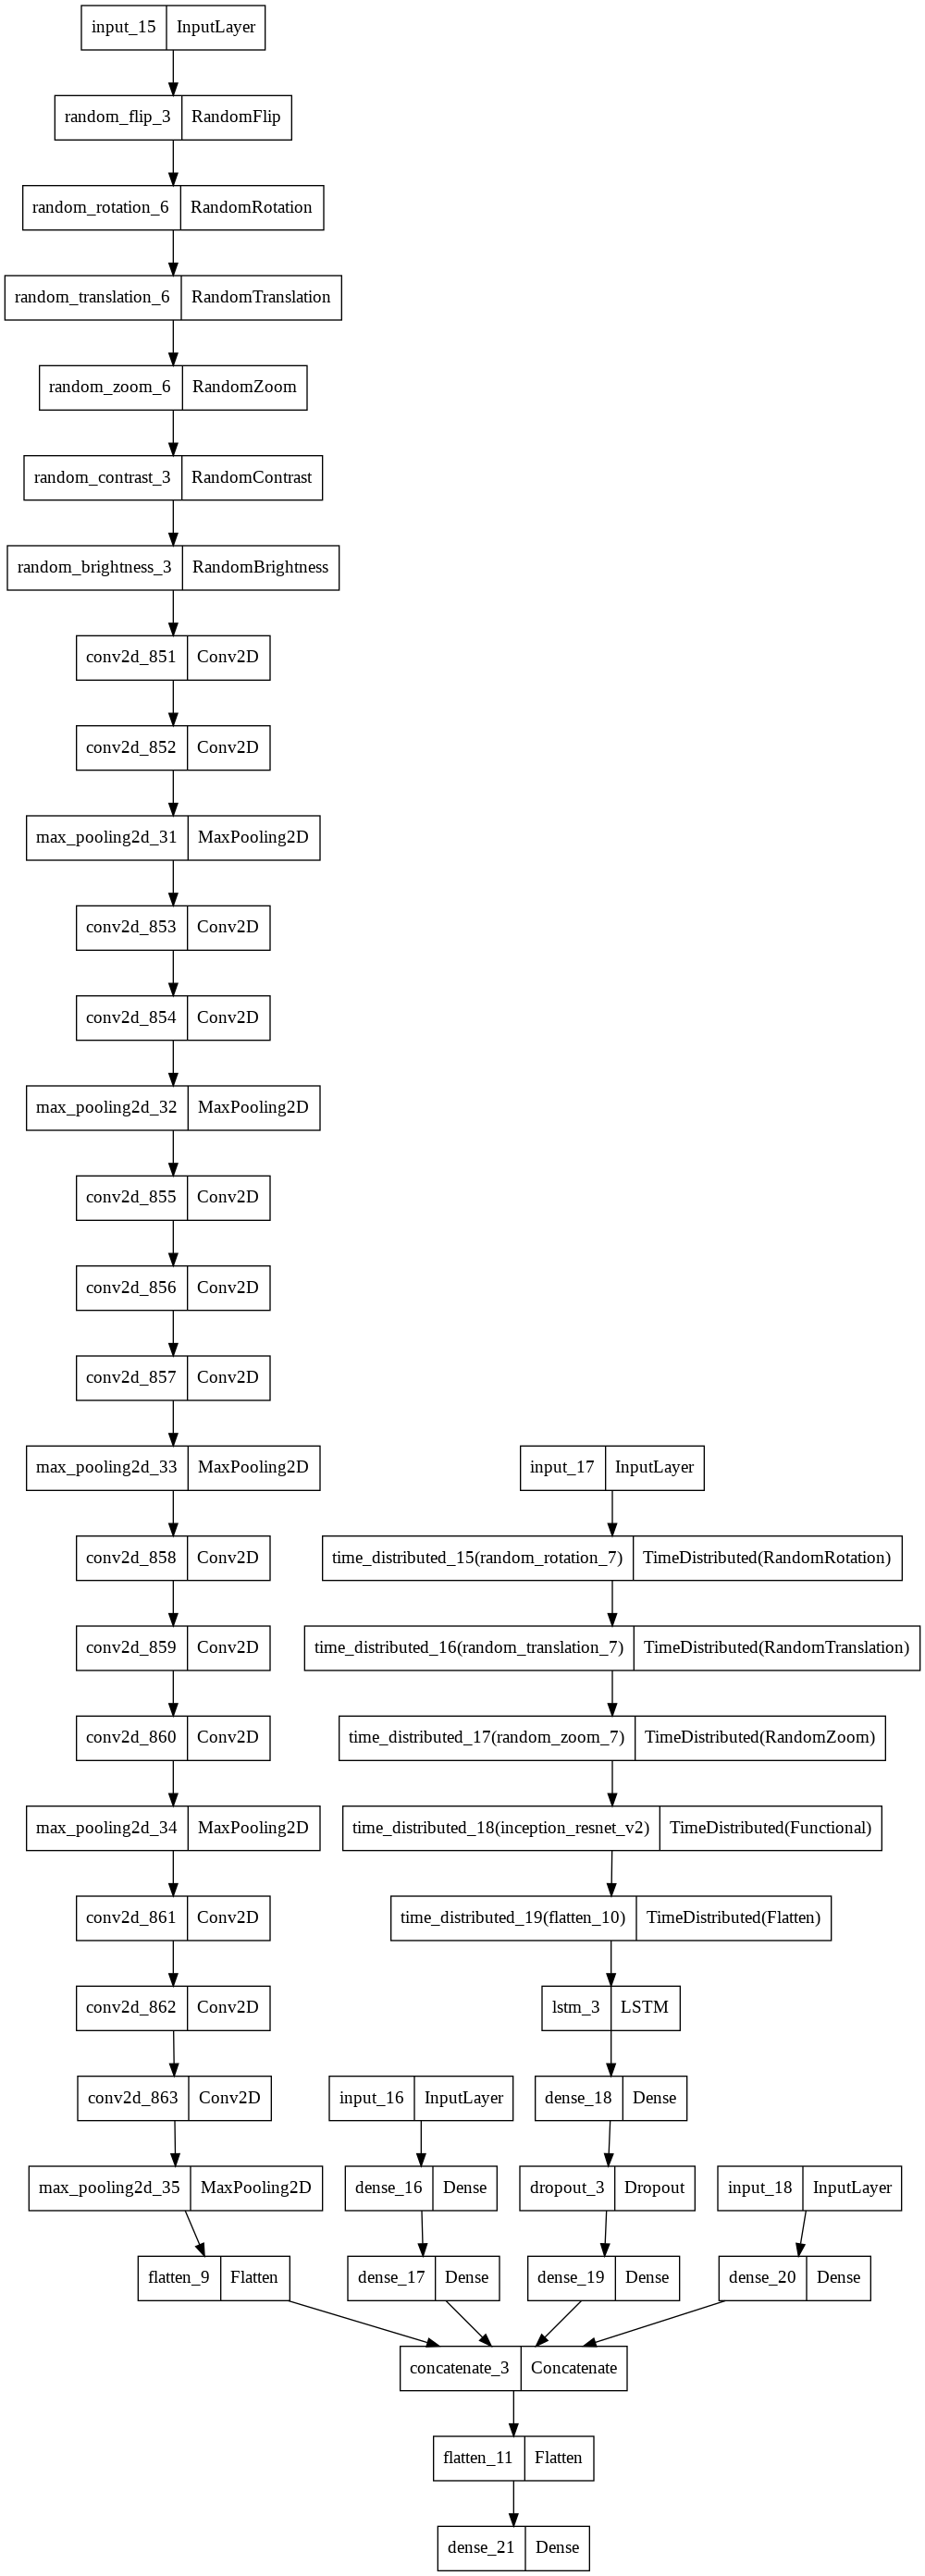

In [ ]:
plot_model(y2_model, to_file='Cnn + Metadata.png')

#9. Data Preparation for 2nd model

In [ ]:
#Reconfirm shuffled_df
shuffled_df = merged_df.sample(frac=1, random_state=0)
shuffled_df

,display_id,view_count,like_count,NPZ_Files
592,3DKlcBW3jW8,553,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
5,3NdohI0ZTj4,495,1,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
141,0QerbXHbsXo,559,8,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
453,1VluC3M16HI,559,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
52,2h_F8niDeKA,2821,2,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
...,...,...,...,...
1033,17ShHvfDLMQ,429,0,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
763,-BGQp5jmoqQ,1106,18,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
835,-LpN5tH_TeA,4434,9,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...
559,3o8TdfUYffU,273650,1536,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...


In [ ]:
#Get predicted like count for all samples by applying model 1
(X_pic, X_stats, X_sliced_video_images), (y1, y2) = get_X_y(shuffled_df)
like_count_prediction = y1_model.predict([X_pic, X_stats, X_sliced_video_images])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#Rest index to avoid errors in pd.concat
shuffled_df = shuffled_df.reset_index(drop=True)

In [ ]:
#adding predicted like counts to shuffled_df
shuffled_df_with_predicted_like_count = pd.concat([shuffled_df, pd.DataFrame(like_count_prediction)], axis=1) #Index is reset
shuffled_df_with_predicted_like_count = shuffled_df_with_predicted_like_count.drop(['like_count'], axis=1)
shuffled_df_with_predicted_like_count.columns = ['display_id', 'view_count', 'NPZ_Files', 'like_count'] #'like_count' is predicted like count
shuffled_df_with_predicted_like_count

,display_id,view_count,NPZ_Files,like_count
0,3DKlcBW3jW8,553,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,81.303879
1,3NdohI0ZTj4,495,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,71.827919
2,0QerbXHbsXo,559,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,80.528328
3,1VluC3M16HI,559,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,48.871265
4,2h_F8niDeKA,2821,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,47.047977
...,...,...,...,...
1202,17ShHvfDLMQ,429,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,49.771988
1203,-BGQp5jmoqQ,1106,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,78.122841
1204,-LpN5tH_TeA,4434,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,104.797867
1205,3o8TdfUYffU,273650,/content/gdrive/MyDrive/NUS/ISY5002_project_wo...,77.695511


In [ ]:
# function to get X_pic, X_stats, and y from a DataFrame
def get_X_y2(df):
  X_pic, X_metadata, X_sliced_video_images = [], [], []
  y1 = []
  y2 = []
  k = 0 #counter
  df = df.reset_index(drop=True)
  for name in df['NPZ_Files']:
    loaded_npz = np.load(name)
    pic = loaded_npz['pic']
    stats = loaded_npz['stats']
    sliced_video_images = loaded_npz['sliced_video_images']
    X_pic.append(pic)
    X_metadata.append(stats)
    X_sliced_video_images.append(sliced_video_images)
    y1.append([df['like_count'][k]]) #Predicted like count instead of given like count as users cannot get like count upfront
    y2.append([loaded_npz['view_count']])    
    print(k)
    k += 1
  X_pic, X_metadata, X_sliced_video_images = np.array(X_pic), np.array(X_metadata), np.array(X_sliced_video_images)
  y1 = np.array(y1)
  y2 = np.array(y2)
  return (X_pic, X_metadata, X_sliced_video_images), (y1, y2)

In [ ]:
train_df2, val_df2, test_df2 = shuffled_df_with_predicted_like_count[:1000], shuffled_df_with_predicted_like_count[1000:1100], shuffled_df_with_predicted_like_count[1100:shuffled_df.shape[0]]
print(len(train_df2),len(val_df2),len(test_df2))
# now the data is ready in these dframes

#Loading the data may take 10 mins
(X_train_pic, X_train_stats, X_train_sliced_video_images), (y1_train, y2_train) = get_X_y2(train_df2) #Train data
(X_val_pic, X_val_stats, X_val_sliced_video_images), (y1_val, y2_val) = get_X_y2(val_df2) #Validation data
(X_test_pic, X_test_stats, X_test_sliced_video_images), (y1_test, y2_test) = get_X_y2(test_df2) #Test data

1000 100 107
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
2

#10. Model Training (2nd model to predict view count)

In [ ]:
y2_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error','mean_squared_error'])

In [ ]:
# Create a model saving callback and train for 10 epochs (connect to GPU runtime!!)
from keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model/', save_best_only=True)
tf.get_logger().setLevel('ERROR') #do not show warning due to data augumentation
r2 = y2_model.fit(x=[X_train_pic, X_train_stats, X_train_sliced_video_images, y1_train], y=y2_train, 
              validation_data=([X_val_pic, X_val_stats, X_val_sliced_video_images, y1_val], y2_val), epochs=3, callbacks=[cp])

Epoch 1/3
32/32 [==============================] - ETA: 0s - loss: 96776110080.0000 - mean_absolute_error: 61935.8242 - mean_squared_error: 96776110080.0000 

32/32 [==============================] - 671s 20s/step - loss: 96776110080.0000 - mean_absolute_error: 61935.8242 - mean_squared_error: 96776110080.0000 - val_loss: 345316064.0000 - val_mean_absolute_error: 14070.6064 - val_mean_squared_error: 345316064.0000
Epoch 2/3
32/32 [==============================] - ETA: 0s - loss: 4839535104.0000 - mean_absolute_error: 17720.1191 - mean_squared_error: 4839535104.0000 

32/32 [==============================] - 638s 20s/step - loss: 4839535104.0000 - mean_absolute_error: 17720.1191 - mean_squared_error: 4839535104.0000 - val_loss: 318572768.0000 - val_mean_absolute_error: 10067.6846 - val_mean_squared_error: 318572768.0000
Epoch 3/3
32/32 [==============================] - 515s 16s/step - loss: 4862356480.0000 - mean_absolute_error: 18159.6426 - mean_squared_error: 4862356480.0000 - val_loss: 331064128.0000 - val_mean_absolute_error: 12890.2930 - val_mean_squared_error: 331064128.0000


In [83]:
# Load the saved model
#from keras.models import load_model
y2_model.save("/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/CNN+LSTM_models_view_count")

In [ ]:
#from keras.models import load_model
#y2_model = load_model("/content/gdrive/MyDrive/NUS/ISY5002_project_work/003_output/CNN+LSTM_models_view_count")

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


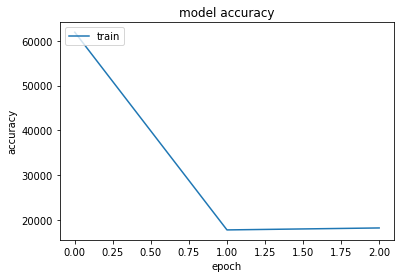

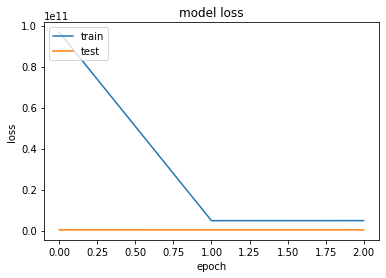

In [ ]:
print(r2.history.keys())
# summarize history for accuracy
plt.plot(r2.history['mean_absolute_error'])
#plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(r2.history['loss'])
plt.plot(r2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim(0,0.5e9)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#11. Test Prediction and Result Evaluation  (2nd model to predict view count)

In [ ]:
#Predict view count by using thubmnails, metadata, sliced video images and predicted like count
test_predictions_view_count = y2_model.predict([X_test_pic, X_test_stats, X_test_sliced_video_images, y1_test])
test_predictions_view_count #predicted view count

4/4 [==============================] - 7s 273ms/step


array([[14561.271 ],
       [11868.919 ],
       [10193.328 ],
       [10625.3   ],
       [15215.818 ],
       [10958.847 ],
       [ 9893.418 ],
       [11158.488 ],
       [10864.77  ],
       [11286.523 ],
       [11495.435 ],
       [10291.216 ],
       [14011.887 ],
       [ 9394.696 ],
       [ 7455.9487],
       [12759.473 ],
       [12412.195 ],
       [12496.05  ],
       [11929.343 ],
       [ 9751.319 ],
       [ 6962.7485],
       [ 7212.2495],
       [10438.442 ],
       [11623.242 ],
       [10815.213 ],
       [12091.668 ],
       [10813.302 ],
       [12063.1   ],
       [10143.448 ],
       [10452.581 ],
       [10493.491 ],
       [12597.036 ],
       [12009.761 ],
       [10466.631 ],
       [12838.586 ],
       [ 9917.609 ],
       [11645.216 ],
       [12720.413 ],
       [15168.038 ],
       [ 7748.6333],
       [11283.04  ],
       [12431.699 ],
       [11654.831 ],
       [ 9520.092 ],
       [11299.708 ],
       [13499.145 ],
       [12987.005 ],
       [ 9333

In [ ]:
#Merge view count data and predicted view count
y2_test_df = pd.DataFrame(y2_test)
test_predictions_view_count_df = pd.DataFrame(test_predictions_view_count)

y2_test_df.columns = ['view_count']
test_predictions_view_count_df.columns = ['predicted_view_count']

test_result_view_count = pd.concat([y2_test_df,test_predictions_view_count_df],axis=1)
test_result_view_count = test_result_view_count.sort_values(by='view_count',axis=0,ascending=False)

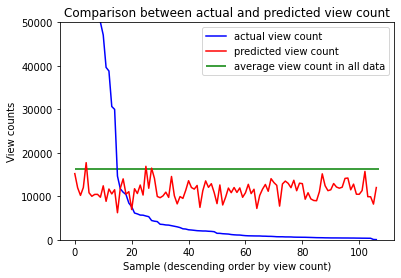

In [ ]:
#Comparison with average
avg = merged_df['view_count'].mean()
plt.ylim(0,50000)
plt.xlabel("Sample (descending order by view count)")
plt.ylabel("View counts")
plt.title("Comparison between actual and predicted view count")
plt.hlines(avg,0,test_result_view_count.shape[0],color='g',label='average view count in all data')
plt.plot(np.arange(0,test_result_view_count.shape[0],1),test_result_view_count['view_count'],color='b',label='actual view count')
plt.plot(np.arange(0,test_result_view_count.shape[0],1),test_result_view_count['predicted_view_count'],color='r',label='predicted view count')
plt.legend()

In [ ]:
#Calculate quantile values
q1 = merged_df['view_count'].quantile(q=0.25)
q2 = merged_df['view_count'].quantile(q=0.5)
q3 = merged_df['view_count'].quantile(q=0.75)
avg = merged_df['view_count'].mean()

view_count_category_avg = []
predicted_view_count_category_avg = []
avg_category_result = []
view_count_category_quantile = []
predicted_view_count_category_quantile = []
quantile_category_result = []

for i in range(test_result_view_count.shape[0]):
  #View count categorisation by average
  if test_result_view_count['view_count'][i] > avg: view_count_category_avg.append('above_average')
  else: view_count_category_avg.append('below_average')

  if test_result_view_count['predicted_view_count'][i] > avg: predicted_view_count_category_avg.append('above_average')
  else: predicted_view_count_category_avg.append('below_average')

  if view_count_category_avg[i] == predicted_view_count_category_avg[i]: avg_category_result.append(True)
  else: avg_category_result.append(False)

  #View count categorisation by quantile
  if test_result_view_count['view_count'][i] > q3: view_count_category_quantile.append('1) Top 25%')
  elif test_result_view_count['view_count'][i] > q2: view_count_category_quantile.append('2) Top 25-50%')
  elif test_result_view_count['view_count'][i] > q1: view_count_category_quantile.append('3) Lower 25-50%')
  else: view_count_category_quantile.append('4) Lowest 25%')

  if test_result_view_count['predicted_view_count'][i] > q3: predicted_view_count_category_quantile.append('1) Top 25%')
  elif test_result_view_count['predicted_view_count'][i] > q2: predicted_view_count_category_quantile.append('2) Top 25-50%')
  elif test_result_view_count['predicted_view_count'][i] > q1: predicted_view_count_category_quantile.append('3) Lower 25-50%')
  else: predicted_view_count_category_quantile.append('4) Lowest 25%')

  if view_count_category_quantile[i] == predicted_view_count_category_quantile[i]: quantile_category_result.append(True)
  else: quantile_category_result.append(False)

view_count_category_avg = pd.DataFrame(view_count_category_avg)
predicted_view_count_category_avg = pd.DataFrame(predicted_view_count_category_avg)
avg_category_result = pd.DataFrame(avg_category_result)
view_count_category_quantile = pd.DataFrame(view_count_category_quantile)
predicted_view_count_category_quantile = pd.DataFrame(predicted_view_count_category_quantile)
quantile_category_result = pd.DataFrame(quantile_category_result)

In [ ]:
print(view_count_category_avg.value_counts())
print('\n')
print(predicted_view_count_category_avg.value_counts())
print('\n')
print(avg_category_result.value_counts())
print('\n')
print(view_count_category_quantile.value_counts())
print('\n')
print(predicted_view_count_category_quantile.value_counts())
print('\n')
print(quantile_category_result.value_counts())

below_average    92
above_average    15
dtype: int64


below_average    104
above_average      3
dtype: int64


True     91
False    16
dtype: int64


2) Top 25-50%      29
4) Lowest 25%      29
3) Lower 25-50%    25
1) Top 25%         24
dtype: int64


1) Top 25%    107
dtype: int64


False    83
True     24
dtype: int64


In [ ]:
category_result = pd.concat([view_count_category_avg,
                             predicted_view_count_category_avg,
                             avg_category_result,
                             view_count_category_quantile,
                             predicted_view_count_category_quantile,
                             quantile_category_result],axis=1)
category_result.columns = ["view_count_category_avg",
                           "predicted_view_count_category_avg",
                           "avg_category_result",
                           "view_count_category_quantile",
                           "predicted_view_count_category_quantile",
                           "quantile_category_result"]

In [ ]:
category_result

,view_count_category_avg,predicted_view_count_category_avg,avg_category_result,view_count_category_quantile,predicted_view_count_category_quantile,quantile_category_result
0,below_average,below_average,True,2) Top 25-50%,1) Top 25%,False
1,below_average,below_average,True,4) Lowest 25%,1) Top 25%,False
2,below_average,below_average,True,3) Lower 25-50%,1) Top 25%,False
3,below_average,below_average,True,3) Lower 25-50%,1) Top 25%,False
4,above_average,below_average,False,1) Top 25%,1) Top 25%,True
...,...,...,...,...,...,...
102,below_average,below_average,True,4) Lowest 25%,1) Top 25%,False
103,below_average,below_average,True,3) Lower 25-50%,1) Top 25%,False
104,below_average,above_average,False,2) Top 25-50%,1) Top 25%,False
105,above_average,below_average,False,1) Top 25%,1) Top 25%,True


In [ ]:
#Confusion matrix for 2 categories (above_average, below_average)
confusion_mat_2cat_view = category_result.pivot_table('avg_category_result', index='view_count_category_avg',columns='predicted_view_count_category_avg', aggfunc='count')
print(confusion_mat_2cat_view)

#metrics calculation
accuracy_view = (confusion_mat_2cat_view['above_average']['above_average']+confusion_mat_2cat_view['below_average']['below_average'])/confusion_mat_2cat_view.sum().sum()
recall_above_abv_avg_view = (confusion_mat_2cat_view['above_average']['above_average'])/confusion_mat_2cat_view.loc['above_average'].sum()
precision_above_abv_avg_view = (confusion_mat_2cat_view['above_average']['above_average'])/confusion_mat_2cat_view['above_average'].sum()
f1_score_abv_avg_view = 2/(1/recall_above_abv_avg_view+1/precision_above_abv_avg_view)

recall_above_blw_avg_view = (confusion_mat_2cat_view['below_average']['below_average'])/confusion_mat_2cat_view.loc['below_average'].sum()
precision_above_blw_avg_view = (confusion_mat_2cat_view['below_average']['below_average'])/confusion_mat_2cat_view['below_average'].sum()
f1_score_blw_avg_view = 2/(1/recall_above_blw_avg_view+1/precision_above_blw_avg_view)

#result
print('\n')
print("Accuracy is "+str(round(accuracy_view,2)))
print('\n')
print("Recall of 'above_average' is "+str(round(recall_above_abv_avg_view,2)))
print("Precision of 'above_average' is "+str(round(precision_above_abv_avg_view,2)))
print("F1 score of 'above_average' is "+str(round(f1_score_abv_avg_view,2)))
print('\n')
print("Recall of 'below_average' is "+str(round(recall_above_blw_avg_view,2)))
print("Precision of 'below_average' is "+str(round(precision_above_blw_avg_view,2)))
print("F1 score of 'below_average' is "+str(round(f1_score_blw_avg_view,2)))

predicted_view_count_category_avg  above_average  below_average
view_count_category_avg                                        
above_average                                  1             14
below_average                                  2             90


Accuracy is 0.85


Recall of 'above_average' is 0.07
Precision of 'above_average' is 0.33
F1 score of 'above_average' is 0.11


Recall of 'below_average' is 0.98
Precision of 'below_average' is 0.87
F1 score of 'below_average' is 0.92
